In [94]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import logging
logging.getLogger("cmdstanpy").disabled = True
import warnings
warnings.filterwarnings('ignore')

In [95]:
# Load datasets
ingredients_df = pd.read_csv("Cleaned_datasets/ingredients_data_cleaned.csv")
sales_df = pd.read_csv("Cleaned_datasets/sales_data_cleaned.csv")

Quantity sold over time

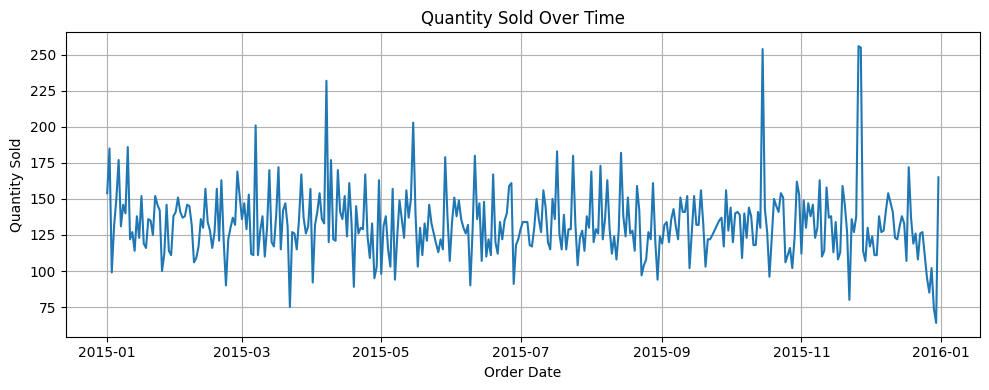

In [96]:
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'])

# Group by order date and sum the quantity
quantity_over_time = sales_df.groupby('order_date')['quantity'].sum()

# Create plot
plt.figure(figsize=(10, 4))
plt.plot(quantity_over_time.index, quantity_over_time.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')

# Display plot
plt.grid(True)
plt.tight_layout()
plt.show()


* Check if quantity_over_time is stationary using the ADF test, and if not, apply differencing until the series becomes stationary.

In [97]:
# Perform the ADF test
adf_result = adfuller(quantity_over_time)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# If p-value is > 0.05, the series is not stationary, so we apply differencing
if adf_result[1] > 0.05:
    quantity_over_time_diff = quantity_over_time.diff().dropna()  # Apply first differencing
    # Re-check stationarity after differencing
    adf_result_diff = adfuller(quantity_over_time_diff)
    print('ADF Statistic (After Differencing):', adf_result_diff[0])
    print('p-value (After Differencing):', adf_result_diff[1])


ADF Statistic: -9.523133325327457
p-value: 3.0271110428710003e-16


Since the ADF Statistic is -9.52 and the p-value is very small (3.03e-16), we can conclude that the time series is stationary. Therefore, we don't need any differencing (d=0), and we can proceed with identifying the AR (p) and MA (q) terms for the ARIMA model.

* ACF Plot: This helps in determining the q (MA order)
* PACF Plot: This helps in determining the p (AR order)

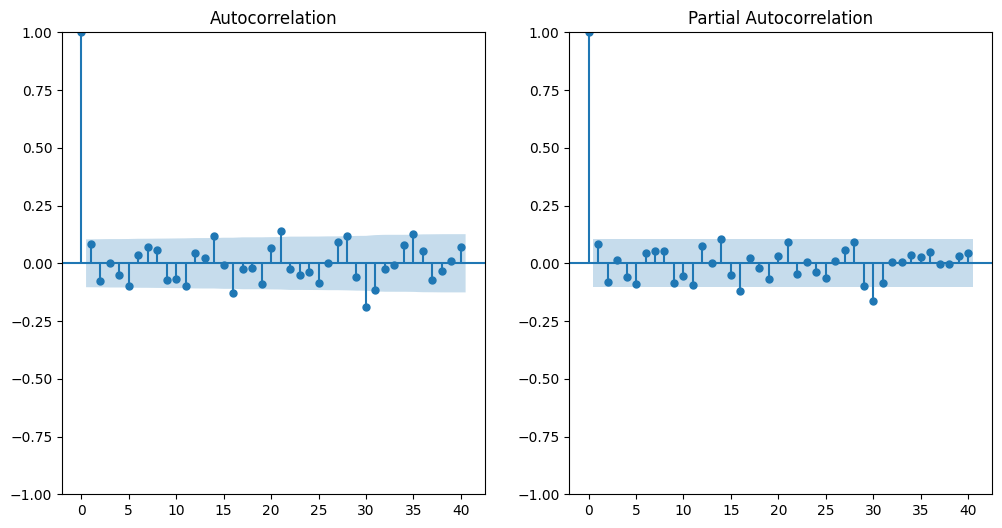

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(quantity_over_time, lags=40, ax=plt.gca())  # ACF plot

# PACF plot
plt.subplot(122)
plot_pacf(quantity_over_time, lags=40, ax=plt.gca())  # PACF plot

plt.show()


Based on the ACF and PACF plots:

* ACF Plot: The ACF plot shows a significant autocorrelation at lag 1 and then gradually diminishes. This suggests that q = 1 (the MA order).

* PACF Plot: The PACF plot shows a significant partial autocorrelation at lag 1, and no significant correlations after that. This suggests that p = 1 (the AR order).

#### 

* p = 1 (AR order)
* d = 0 (since the series is stationary)
* q = 1 (MA order)

#### Model training

In [99]:
# sort pizza_name columns using date and calculate its respective quantity sold
pizza_data = sales_df.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)
# take one test pizza column for training models and checking its prediction
test_pizza_column = pizza_data['the california chicken pizza']

In [100]:
pizza_data

pizza_name,the barbecue chicken pizza,the big meat pizza,the brie carre pizza,the calabrese pizza,the california chicken pizza,the chicken alfredo pizza,the chicken pesto pizza,the classic deluxe pizza,the five cheese pizza,the four cheese pizza,...,the prosciutto and arugula pizza,the sicilian pizza,the soppressata pizza,the southwest chicken pizza,the spicy italian pizza,the spinach and feta pizza,the spinach pesto pizza,the spinach supreme pizza,the thai chicken pizza,the vegetables + vegetables pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,2.0,5.0,7.0,3.0
2015-01-02,12.0,5.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,4.0,5.0,3.0,8.0,1.0
2015-01-03,2.0,3.0,1.0,1.0,6.0,0.0,1.0,4.0,5.0,4.0,...,1.0,2.0,0.0,9.0,4.0,5.0,3.0,0.0,4.0,6.0
2015-01-04,2.0,3.0,0.0,2.0,3.0,3.0,2.0,8.0,7.0,6.0,...,4.0,8.0,6.0,10.0,4.0,1.0,4.0,6.0,3.0,5.0
2015-01-05,6.0,1.0,1.0,4.0,11.0,2.0,3.0,9.0,4.0,4.0,...,5.0,5.0,0.0,6.0,5.0,5.0,2.0,4.0,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,4.0,3.0,1.0,1.0,3.0,0.0,3.0,8.0,2.0,2.0,...,1.0,4.0,1.0,2.0,4.0,1.0,3.0,1.0,5.0,9.0
2015-12-28,2.0,3.0,1.0,1.0,5.0,2.0,3.0,9.0,2.0,4.0,...,5.0,4.0,5.0,3.0,2.0,3.0,2.0,2.0,6.0,3.0
2015-12-29,4.0,2.0,1.0,2.0,4.0,1.0,1.0,3.0,3.0,3.0,...,3.0,2.0,3.0,1.0,3.0,1.0,4.0,0.0,5.0,1.0


#### split train and test data

In [101]:
# split train and test
train = test_pizza_column[:-7]
test = test_pizza_column[-7:]

In [102]:
test

order_date
2015-12-24    6.0
2015-12-26    3.0
2015-12-27    3.0
2015-12-28    5.0
2015-12-29    4.0
2015-12-30    7.0
2015-12-31    7.0
Name: the california chicken pizza, dtype: float64

### ARIMA

In [103]:
# Define the ARIMA model
arima_model = ARIMA(train, order=(1, 0, 1))

# Fit the ARIMA model
arima_fit = arima_model.fit()

# Forecast the next 7 days
arima_forecast = arima_fit.forecast(steps=len(test))
arima_forecast.index = test.index

# Concatenate the actual and predicted values
concatenated_arima = pd.concat([test, arima_forecast], axis=1)
concatenated_arima.columns = ['Actual', 'Predicted']
concatenated_arima

,Actual,Predicted
order_date,,
2015-12-24,6.0,6.403808
2015-12-26,3.0,6.128895
2015-12-27,3.0,6.387393
2015-12-28,5.0,6.144330
2015-12-29,4.0,6.372880
2015-12-30,7.0,6.157977
2015-12-31,7.0,6.360048


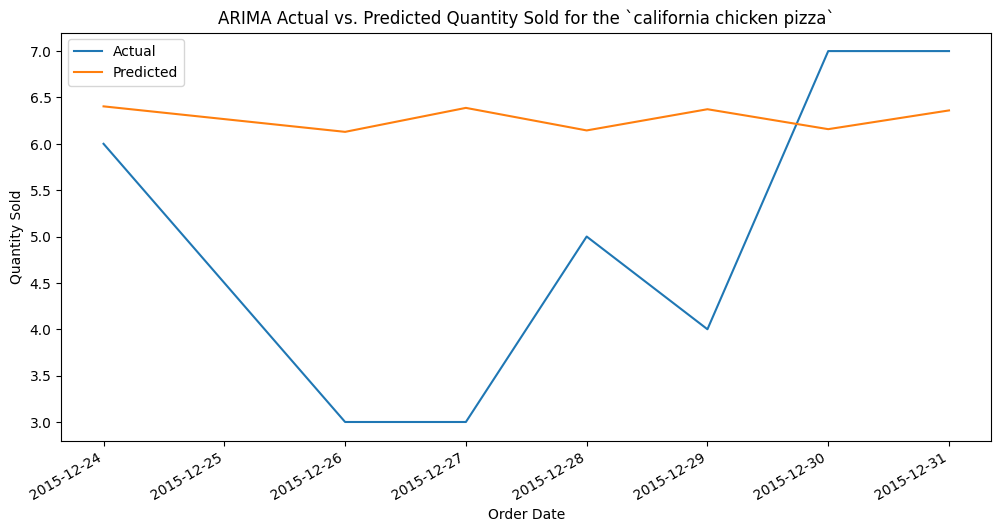

In [104]:
concatenated_arima.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('ARIMA Actual vs. Predicted Quantity Sold for the `california chicken pizza`')
plt.show()

In [105]:
# Evaluate the model
mae = mean_absolute_error(test, arima_forecast)
mse = mean_squared_error(test, arima_forecast)
rmse = np.sqrt(mse)

print(f'ARIMA MAE: {mae}')
print(f'ARIMA MSE: {mse}')
print(f'ARIMA RMSE: {rmse}')

ARIMA MAE: 1.702754558147763
ARIMA MSE: 4.212296106695329
ARIMA RMSE: 2.052387903563878


#### SARIMA

In [106]:
# Define the SAARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))

# Fit the ARIMA model
sarima_result = sarima_model.fit()

# Forecast the next 7 days
sarima_forecast = sarima_result.get_forecast(steps=len(test))
sarima_fore_values = sarima_forecast.predicted_mean
sarima_fore_values.index = test.index

# Concatenate the actual and predicted values
concatenated_sarima = pd.concat([test, sarima_fore_values] , axis=1)
concatenated_sarima.columns = ['Actual', 'Predicted']
concatenated_sarima

,Actual,Predicted
order_date,,
2015-12-24,6.0,5.667113
2015-12-26,3.0,6.299321
2015-12-27,3.0,5.987047
2015-12-28,5.0,6.721027
2015-12-29,4.0,5.250721
2015-12-30,7.0,5.891442
2015-12-31,7.0,5.514327


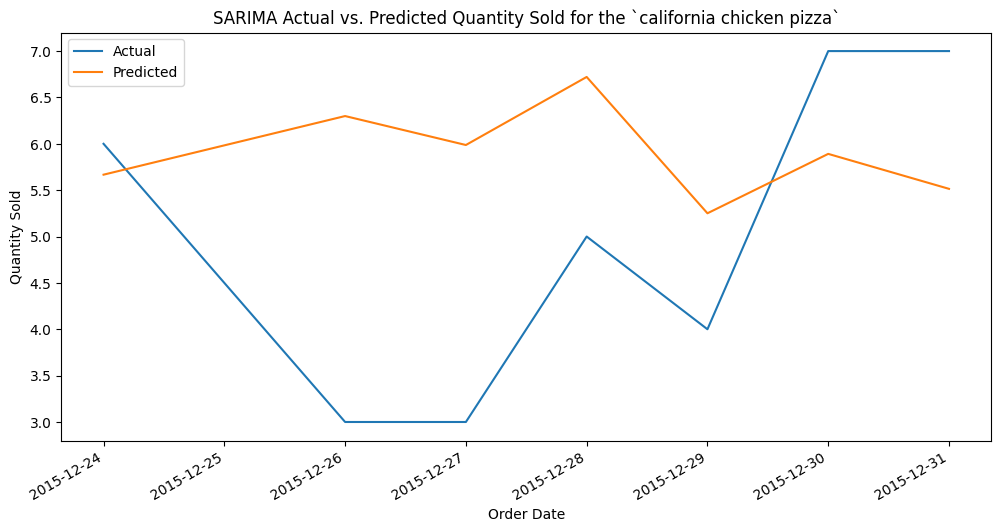

In [107]:
concatenated_sarima.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('SARIMA Actual vs. Predicted Quantity Sold for the `california chicken pizza`')
plt.show()

In [108]:
# Evaluate Sarima
mae = mean_absolute_error(test, sarima_fore_values)
mse = mean_squared_error(test, sarima_fore_values)
rmse = np.sqrt(mse)

print(f'SARIMAX MAE: {mae}')
print(f'SARIMAX MSE: {mse}')
print(f'SARIMAX RMSE: {rmse}')

SARIMAX MAE: 1.740747568616767
SARIMAX MSE: 3.983020162552745
SARIMAX RMSE: 1.9957505261311457


#### PROPHET

In [109]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data = test_pizza_column.reset_index()
prophet_data.columns = ['ds', 'y']

# Define the Prophet model
prophet_model = Prophet(weekly_seasonality=True)

# Fit the Prophet model
prophet_model.fit(prophet_data)

# Create a dataframe for future dates
future_dates = prophet_model.make_future_dataframe(periods=7)

# Forecast the next 7 days
prophet_forecast = prophet_model.predict(future_dates)

# Extract the forecasted values
prophet_forecast_values = prophet_forecast[['ds', 'yhat']].set_index('ds').iloc[-7:]
prophet_forecast_values.columns = ['Predicted']
prophet_forecast_values.index = test.index

# Concatenate the actual and predicted values
concatenated_prophet = pd.concat([test, prophet_forecast_values], axis=1)
concatenated_prophet.columns = ['Actual', 'Predicted']
concatenated_prophet

,Actual,Predicted
order_date,,
2015-12-24,6.0,6.831083
2015-12-26,3.0,5.812976
2015-12-27,3.0,5.035795
2015-12-28,5.0,5.952823
2015-12-29,4.0,5.332053
2015-12-30,7.0,5.639627
2015-12-31,7.0,5.995109


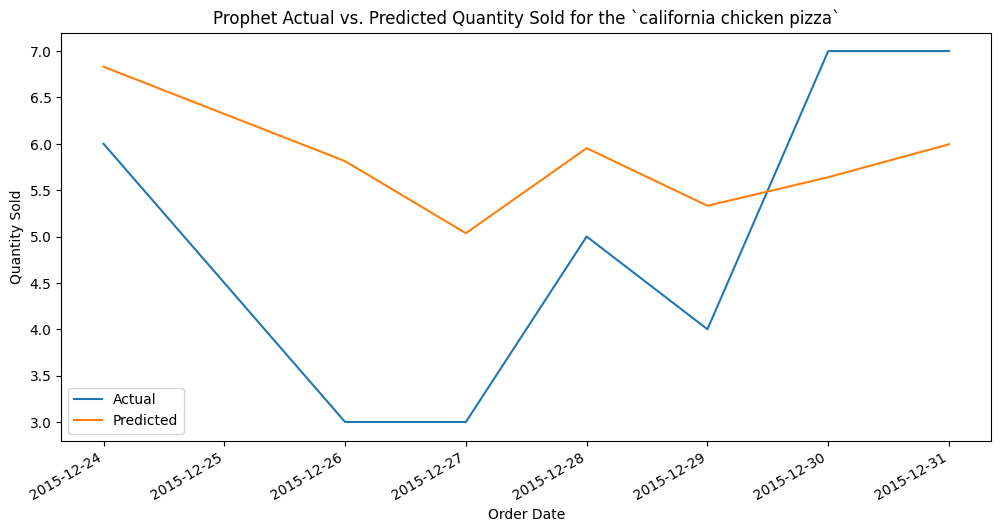

In [110]:
concatenated_prophet.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Prophet Actual vs. Predicted Quantity Sold for the `california chicken pizza`')
plt.show()

In [111]:
# Evaluate the Prophet model
mae_prophet = mean_absolute_error(test, prophet_forecast_values)
mse_prophet = mean_squared_error(test, prophet_forecast_values)
rmse_prophet = np.sqrt(mse_prophet)

print(f'Prophet MAE: {mae_prophet}')
print(f'Prophet MSE: {mse_prophet}')
print(f'Prophet RMSE: {rmse_prophet}')

Prophet MAE: 1.4757133103910327
Prophet MSE: 2.6129499260938442
Prophet RMSE: 1.6164621635206449


FROM THE RESULT COMPARISON WE CAN CONCLUDE THAT ### PROPHET ### IS THE BEST PERFORMING MODEL